## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

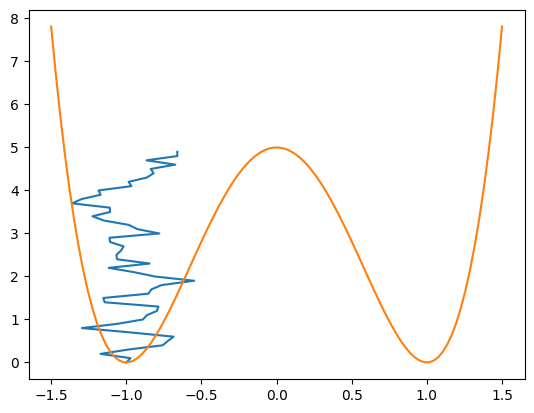

In [3]:
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

## Brownian motion prior, brownian bridge posterior

Schedule: [0.01, 0.02]
old s 0.0
Train loss: 16529.8203125
Test loss is 66813228.0
old s 0.01
Train loss: 13443.0712890625
Test loss is 1034945984.0


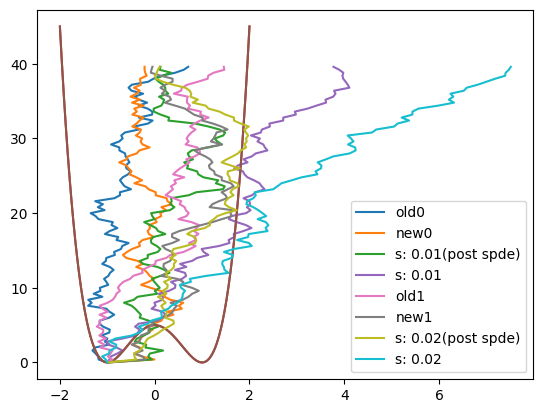

In [11]:
key = jax.random.key(0)
# schedule = np.linspace(0,1, 5)
schedule = [0.01, 0.02] # obviously should be extended to 1, but just to see early steps...
print("Schedule:", schedule)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' : 200}

b = lambda x, t: 0.0
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(1))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # for simplicity, I consider the version where a new NN is learned at each s. The alternative version is commented out below
    b, A = update_non_amortized(
        V=lambda x: 0.0,
        b=b,
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A=A,
        refine=True
    )
    
    # dbds, A = update(
    #     V=lambda x: 0.0,
    #     uref=b,
    #     J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
    #     dbds=dbds,
    #     hyperparams=hyperparams,
    #     key=key,
    #     schedule=schedule,
    #     i=i,
    #     prior='sde_prior',
    #     A=A,
    #     refine=True
    # )


## Now use the learned b to generate new paths

In [12]:
from path_sampling import make_b

# if using the version with a single NN (commented out above)
# b = make_b(schedule, uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-1,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))

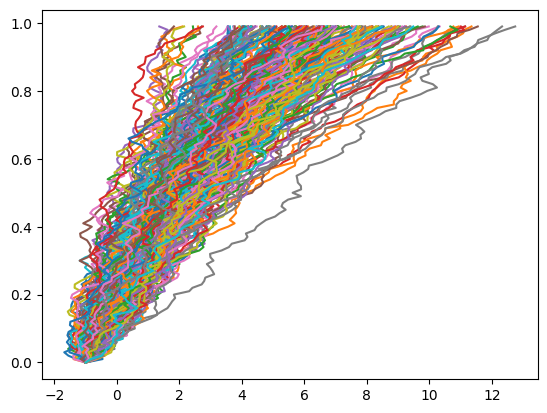

In [13]:
for path in xs:
    plt.plot(path, times[0])

# and compare to exact brownian bridge

(ignore the double well in the background - just a plotting artifact)

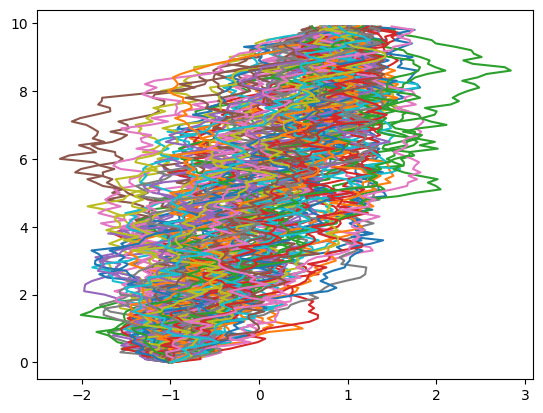

In [10]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (1 - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 100))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)
